In [7]:
import numpy as np
import sys
import os
sys.path.append('../')
import matplotlib.pyplot as plt

from run_pwh_cls import classify_pair, select_k, SpectrumData

In [2]:

def get_power_thresholds(sp_human: SpectrumData, sp_model: SpectrumData, k_threshold: int, n_intervals: int):
    human_power = sp_human.spectrum_df.groupby('sid').head(k_threshold)['power']
    model_power = sp_model.spectrum_df.groupby('sid').head(k_threshold)['power']
    human_mean = human_power.mean()
    model_mean = model_power.mean()
    higher = 'model' if human_mean < model_mean else 'human'

    low = min(human_power.min(), model_power.min())
    high = max(human_power.max(), model_power.max())
    mid = (low + high) / 2
    low_thresholds = np.linspace(low, mid, n_intervals)
    high_thresholds = np.linspace(mid, high, n_intervals)
    power_thresholds = np.concatenate([low_thresholds[:-1], high_thresholds])

    return power_thresholds, higher

def classify(x, k_threshold, power_threshold, heuristics='>'):
    preds = 0
    for sid in x.keys():
        power = x[sid]['power']
        if heuristics == '>':
            if np.mean(power[:k_threshold]) > power_threshold:
                preds += 1
        elif heuristics == '<':
            if np.mean(power[:k_threshold]) < power_threshold:
                preds += 1
    return preds, len(x)
        

def get_roc(sp_human, sp_model, k_threshold, n_intervals=5):
    """
    Positive: model-generated
    Negative: human-written
    ROC curve is TPR vs. FPR
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    """
    roc_results = []
    power_thresholds, higher = get_power_thresholds(sp_human, sp_model, k_threshold, n_intervals=n_intervals)
    x_human = sp_human.get_dict()
    x_model = sp_model.get_dict()

    for power_threshold in power_thresholds:
        if higher == 'model':
            TP, P = classify(x_model, k_threshold, power_threshold, heuristics='>')
            FP, N = classify(x_human, k_threshold, power_threshold, heuristics='>')
        elif higher == 'human':
            TP, P = classify(x_model, k_threshold, power_threshold, heuristics='<')
            FP, N = classify(x_human, k_threshold, power_threshold, heuristics='<')
        TPR = TP / P
        FPR = FP / N
        roc_results.append((TPR, FPR))

    return sorted(roc_results, key=lambda x: x[1]) 

In [25]:
n = 5
left_range = np.linspace(0, 1, n+1)
right_range = np.linspace(1, 2, n+1)
print(np.concatenate([left_range[:-1], right_range]).shape)

(11,)


In [ ]:
def eval_loop(dataset: str):
    """
    dataset: str, 'gpt-4', 'gpt-3.5', or 'gpt-3'
    """
    print(f'Evaluation for {dataset}')
    for genre in ['pubmed']: # , 'writing', 'xsum'
        print(f'Genre: {genre}')
        for est_name in ['gpt2xl']: # , 'mistral', 'bigram'
            human_filename = f'../data/{genre}/{genre}_{dataset}.original.{est_name}.nllzs.fftnorm.txt'
            model_filename = f'../data/{genre}/{genre}_{dataset}.sampled.{est_name}.nllzs.fftnorm.txt'
            if not os.path.exists(human_filename) or not os.path.exists(model_filename):
                continue
            sp_human = SpectrumData(human_filename)
            x_human = sp_human.get_dict()
            sp_model = SpectrumData(model_filename)
            x_model = sp_model.get_dict()

            best_k_1, best_acc_1 = select_k(x_human, x_model, higher='human')
            best_k_2, best_acc_2 = select_k(x_human, x_model, higher='model')
            if best_acc_1 > best_acc_2:
                best_k = best_k_1
                best_acc = best_acc_1
                higher = 'human'
            else:
                best_k = best_k_2
                best_acc = best_acc_2
                higher = 'model'

            roc_results = get_roc(x_human, x_model, higher=higher)

            print(f'   {genre}, {est_name}, best_k={best_k}, best_acc={best_acc:.4f}, higher={higher}')
            print(roc_results)
    print()

In [14]:
eval_loop('gpt-4')

Evaluation for gpt-4
Genre: pubmed
   pubmed, gpt2xl, best_k=3, best_acc=0.9133, higher=model
[(0.6133333333333333, 0.38666666666666666), (0.45333333333333337, 0.5466666666666666), (0.45333333333333337, 0.5466666666666666), (0.44666666666666666, 0.5533333333333333), (0.44666666666666666, 0.5533333333333333), (0.43999999999999995, 0.56), (0.43999999999999995, 0.56), (0.43999999999999995, 0.56), (0.43333333333333335, 0.5666666666666667), (0.43333333333333335, 0.5666666666666667), (0.43333333333333335, 0.5666666666666667), (0.43333333333333335, 0.5666666666666667), (0.43333333333333335, 0.5666666666666667), (0.43333333333333335, 0.5666666666666667), (0.42666666666666664, 0.5733333333333334), (0.42666666666666664, 0.5733333333333334), (0.42666666666666664, 0.5733333333333334), (0.42666666666666664, 0.5733333333333334), (0.42000000000000004, 0.58), (0.42000000000000004, 0.58), (0.42000000000000004, 0.58), (0.4, 0.6), (0.3933333333333333, 0.6066666666666667), (0.3933333333333333, 0.606666666

In [4]:
dataset = 'gpt-4'
# dataset = 'gpt-3.5'
genre = 'pubmed'
# genre = 'xsum'
est_name = 'gpt2xl'

human_filename = f'../data/{genre}/{genre}_{dataset}.original.{est_name}.nllzs.fftnorm.txt'
model_filename = f'../data/{genre}/{genre}_{dataset}.sampled.{est_name}.nllzs.fftnorm.txt'
sp_human = SpectrumData(human_filename)
x_human = sp_human.get_dict()
sp_model = SpectrumData(model_filename)
x_model = sp_model.get_dict()

In [ ]:
# plot roc_results

plt.plot([x[0] for x in roc_results], [x[1] for x in roc_results])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {genre} {est_name} {dataset}')

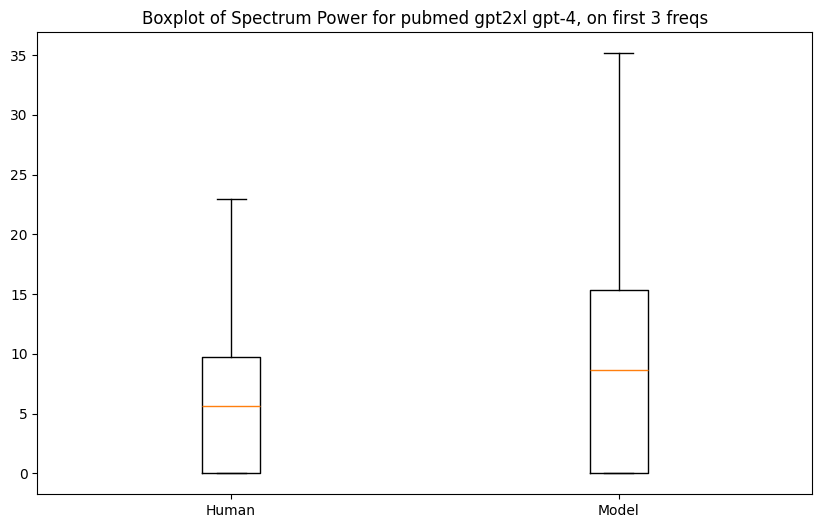

In [5]:
# plot the density curves of spectrum power
k_threshold = 3

# group by sid and select the first k rows 
human_power = sp_human.spectrum_df.groupby('sid').head(k_threshold)['power']
model_power = sp_model.spectrum_df.groupby('sid').head(k_threshold)['power']

# boxplot
plt.figure(figsize=(10, 6))
# plt.violinplot([human_power, model_power])
plt.boxplot([human_power, model_power], tick_labels=['Human', 'Model'])
plt.title(f'Boxplot of Spectrum Power for {genre} {est_name} {dataset}, on first {k_threshold} freqs')
plt.show()

In [7]:
# Scramble the spectrum and classify
k_threshold = 3 
human_power = sp_human.spectrum_df.groupby('sid').head(k_threshold)['power']
model_power = sp_model.spectrum_df.groupby('sid').head(k_threshold)['power']
power_threshold = (human_power.mean() + model_power.mean()) / 2
x_human = sp_human.get_dict()
x_model = sp_model.get_dict()

TP, P = classify(x_model, k_threshold, power_threshold, heuristics='>')
print(f'TP = {TP}, P = {P}')
FP, N = classify(x_human, k_threshold, power_threshold, heuristics='>')
print(f'FP = {FP}, N = {N}')

TP = 110, P = 150
FP = 36, N = 150


In [10]:
TPRs, FPRs = [], []
for k_threshold in range(2, 20):
    human_power = sp_human.spectrum_df.groupby('sid').head(k_threshold)['power']
    model_power = sp_model.spectrum_df.groupby('sid').head(k_threshold)['power']
    power_threshold = (human_power.mean() + model_power.mean()) / 2
    x_human = sp_human.get_dict()
    x_model = sp_model.get_dict()
    TP, P = classify(x_model, k_threshold, power_threshold, heuristics='>')
    TPRs.append(TP / P)
    FP, N = classify(x_human, k_threshold, power_threshold, heuristics='>')
    FPRs.append(FP / N)
# print(TPRs, FPRs)

In [ ]:
# scatter plot of TPR vs FPR
plt.scatter(FPRs, TPRs)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {genre} {est_name} {dataset}')
plt.xlim(0,1.01)
plt.ylim(0,1.01)
plt.show()

In [11]:
roc_results = get_roc(sp_human, sp_model, k_threshold=3, n_intervals=50)

TPRs = [roc[0] for roc in roc_results]
FPRs = [roc[1] for roc in roc_results]
print(TPRs)
print(FPRs)
# print(roc_results)

[0.05333333333333334, 0.04666666666666667, 0.04, 0.03333333333333333, 0.02, 0.006666666666666667, 0.006666666666666667, 0.006666666666666667, 0.006666666666666667, 0.006666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12, 0.08, 0.16, 0.14, 0.25333333333333335, 0.22, 0.2, 0.3, 0.4533333333333333, 0.36, 0.5, 0.5466666666666666, 0.6133333333333333, 0.6666666666666666, 0.72, 0.7666666666666667, 0.8, 0.86, 0.9066666666666666, 0.9133333333333333, 0.9333333333333333, 0.9733333333333334, 0.9866666666666667, 0.9933333333333333, 0.9933333333333333, 0.9933333333333333, 0.9933333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

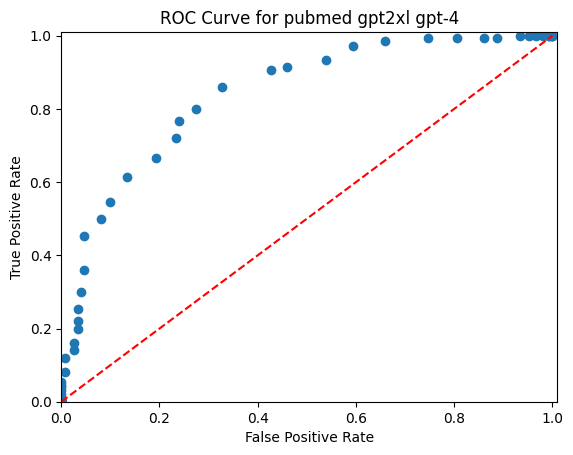

In [12]:
# scatter plot of TPR vs FPR
plt.scatter(FPRs, TPRs)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {genre} {est_name} {dataset}')
plt.xlim(0,1.01)
plt.ylim(0,1.01)
plt.show()